Import libraries

In [1]:
import librosa
import librosa.display
import seaborn as sns
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.image import resize

Define directories and genres

In [2]:
DATA_DIR=("/content/drive/MyDrive/genres_original")
genres = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

Audio preprocessing

In [3]:
from tensorflow.image import resize

def load_and_preprocess_data(data_dir,classes,target_shape=(150,150)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        class_dir = os.path.join(data_dir,class_name)
        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir,filename)
                audio_data,sample_rate = librosa.load(file_path,sr=None)
                #Performing Preprocessing
                #define the duration of each chunk and overlap
                chunk_duration = 4
                overlap_duration = 2

                #Convert duration to sample
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                #Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1

                #iterate over each chunks
                for i in range(num_chunks):
                    #Calculate start and end indices of the chunk
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    #Extract the chunk audio
                    chunk = audio_data[start:end]
                    #Melspectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                    #Resize matrix based on provided target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                    #Append data to list
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    #Return
    return np.array(data),np.array(labels)


Function for test data preprocessing

In [4]:
from tensorflow.image import resize

def mel_spectograms(data_dir,target_shape=(150,150)):
    data=[]
    audio_data,sample_rate = librosa.load(data_dir,sr=None)
    chunk_duration = 4
    overlap_duration = 2

    chunk_samples = chunk_duration * sample_rate
    overlap_samples = overlap_duration * sample_rate
    num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1


    for i in range(num_chunks):
        start = i*(chunk_samples-overlap_samples)
        end = start+chunk_samples
        chunk = audio_data[start:end]
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)

        mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
        data.append(mel_spectrogram)


    return np.array(data)


In [5]:
def predict(test_data):
  prediction = model.predict(test_data)
  predicted_categories= np.argmax(prediction, axis=1)
  unique_elements,counts=np.unique(predicted_categories,return_counts=True)
  max_count=np.max(counts)
  max_elements=unique_elements[counts==max_count]
  final_genre=genres[max_elements[0]]
  print(f"Predicted genre: {final_genre}")

In [6]:
data,labels = load_and_preprocess_data(DATA_DIR,genres)

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


Splitting the data into training and test data


(2995,)


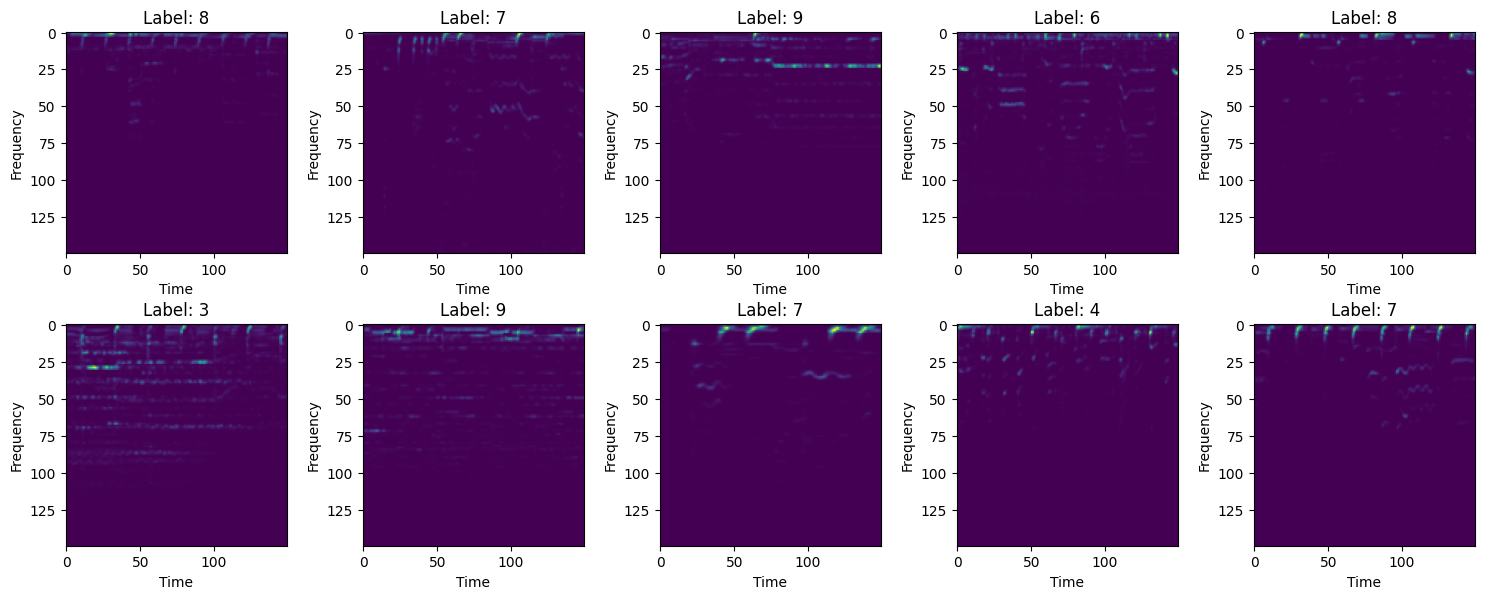

In [7]:
encoder=LabelEncoder()
labels_encoded=encoder.fit_transform(labels)

X_train, X_test, Y_train, Y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

fig, axes = plt.subplots(2,5, figsize=(15,6))
axes=axes.flatten()
print(Y_test.shape)
for i in range(10):
    img= X_train[i]
    im= axes[i].imshow(img)
    axes[i].set_title(f"Label: {Y_train[i]}")
    axes[i].set_xlabel(f"Time")
    axes[i].set_ylabel(f"Frequency")
plt.tight_layout()
plt.show()

Defining the CNN model

In [8]:
input_shape = X_train[0].shape
model= keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu",padding='same', input_shape=input_shape),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3, strides=(2,2), padding='same'),

    layers.Conv2D(64, (3,3),padding='same', activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3, strides=(2,2), padding='same'),

    layers.Conv2D(128, (3,3), padding='same', activation="relu"),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3, strides=(2,2), padding='same'),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), padding='same',activation="relu"),
    layers.Conv2D(256, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3, strides=(2,2), padding='same'),

    layers.Conv2D(512, (3,3), padding='same', activation="relu"),
    layers.Conv2D(512, (3,3),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3, strides=(2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(units=1200, activation="relu"),
    layers.Dropout(0.45),
    layers.Dense(len(genres), activation="softmax")
])


model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,186,426 (27.41 MB)

 Trainable params: 7,184,442 (27.41 MB)

 Non-trainable params: 1,984 (7.75 KB)

Training the model


In [9]:
history=model.fit(X_train,Y_train, epochs=30, batch_size=32,validation_data=(X_val,Y_val), verbose=1)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 152ms/step - accuracy: 0.2009 - loss: 3.4290 - val_accuracy: 0.2250 - val_loss: 2.3156
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.3749 - loss: 1.8390 - val_accuracy: 0.4578 - val_loss: 1.5684
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.4617 - loss: 1.5538 - val_accuracy: 0.5522 - val_loss: 1.3273
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.5517 - loss: 1.3066 - val_accuracy: 0.5088 - val_loss: 1.4006
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.5815 - loss: 1.2030 - val_accuracy: 0.5839 - val_loss: 1.1580
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.6562 - loss: 1.0263 - val_accuracy: 0.5826 - val_loss: 1.2290
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.6800 - loss: 0.9102 - val_accuracy: 0.6093 - val_loss: 1.1354
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.7247 - loss: 0.8067 -

Plotting the graph between training and validation accuracy


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8591 - loss: 0.5190
Test Accuracy: 0.8634


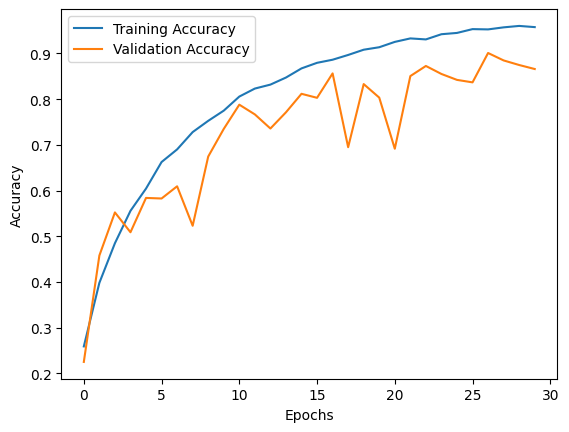

In [10]:
test_loss,test_accuracy= model.evaluate(X_test,Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
model.save("/content/drive/MyDrive/music_genre_classifier_model.h5")

Classification Report

In [16]:
model=keras.models.load_model("/content/drive/MyDrive/music_genre_classifier_model.h5")
y_predict=model.predict(X_test)
predicted_cat=np.argmax(y_predict,axis=1)

from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(Y_test,predicted_cat)
print(classification_report(Y_test,predicted_cat,target_names=genres))
print(cm)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
              precision    recall  f1-score   support

       blues       0.89      0.86      0.87       302
   classical       0.92      0.97      0.94       298
     country       0.72      0.82      0.77       317
       disco       0.92      0.91      0.92       312
      hiphop       0.93      0.87      0.90       277
        jazz       0.69      0.95      0.80       311
       metal       0.96      0.95      0.95       302
         pop       0.96      0.86      0.91       289
      reggae       0.89      0.80      0.84       296
        rock       0.91      0.63      0.75       291

    accuracy                           0.86      2995
   macro avg       0.88      0.86      0.86      2995
weighted avg       0.88      0.86      0.86      2995

[[260   0   7   0   0  32   0   0   2   1]
 [  0 290   1   0   0   7   0   0   0   0]
 [  5   9 261   0   0  36   0   0   1   5]
 [  0   2  15 284   3   4   2   1   1   0]
 [  0   0   1   1 241   0   2

Confusion Matrix

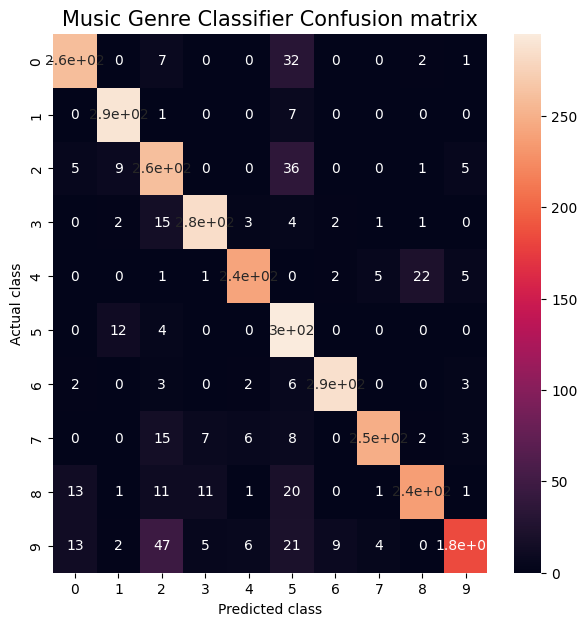

In [17]:
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted class",fontsize=10)
plt.ylabel("Actual class",fontsize=10)
plt.title("Music Genre Classifier Confusion matrix",fontsize=15)
plt.show()

In [18]:
file_path = input("Enter the file path of the song: ")
test_data=mel_spectograms(file_path)
predict(test_data)

Enter the file path of the song: /content/drive/MyDrive/The Strokes - Reptilia (Official HD Video).mp3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step
Predicted genre: rock
